In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 974.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.0 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F

# Load the dataset
data_path = '/content/sample_data/Perovskite_Stability_with_features.csv'  # Update this path to your dataset location
df = pd.read_csv(data_path)

# Define a function to label stability based on 'energy_above_hull'
def label_stability(energy_above_hull, threshold=50):
    """
    Label materials as stable (1) or unstable (0) based on the energy above the hull.
    Args:
        energy_above_hull (float): The energy above the hull in meV/atom.
        threshold (float): The threshold below which a material is considered stable.
    Returns:
        int: 1 if stable, 0 if unstable.
    """
    return 1 if energy_above_hull < threshold else 0

# Apply the labeling function to create a new column in the DataFrame
df['stability_label'] = df['energy_above_hull (meV/atom)'].apply(label_stability)

# Define the features to use for node representation
feature_columns = [
    'host_Asite0_Heat of Vaporization', 'host_Bsite0_at. wt.',
    'host_Bsite0_Ionization Energy (kJ/mol)', 'shannon_radii_AB_avg',
    'Density_AB_avg', 'covalent radius_AB_avg', 'Ionization Energy (kJ/mol)_AB_avg',
    'Electron Affinity (kJ/mol)_AB_avg', 'Atomic Volume (cm³/mol)_AB_avg',
    'MendeleevNumber_AB_avg', 'First Ionization Potential (V)_AB_avg'
]

# Fill missing values and standardize the features
df[feature_columns] = df[feature_columns].fillna(df[feature_columns].mean())
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

def create_graph(material_row):
    """
    Create a graph data object from a material's properties.
    Args:
        material_row (pd.Series): The row containing material data.
    Returns:
        Data: A graph data object with nodes and edges.
    """
    node_features = []

    # Create node features based on A, B, and X site elements
    for site in ['A site #1', 'A site #2', 'A site #3', 'B site #1', 'B site #2', 'B site #3', 'X site']:
        element = material_row[site]
        if pd.notna(element):
            # Use averaged features for each site as node features
            node_feature = material_row[feature_columns].values
            node_features.append(node_feature)

    node_features = torch.tensor(node_features, dtype=torch.float)

    # Define edges based on the relationships between the nodes
    edge_index = []
    num_nodes = len(node_features)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            edge_index.append([i, j])
            edge_index.append([j, i])  # Add reverse edge for undirected graph

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Define the label for the graph
    label = torch.tensor([material_row['stability_label']], dtype=torch.long)

    # Create the graph data object
    return Data(x=node_features, edge_index=edge_index, y=label)

# Create graph data objects for the training and testing sets
train_graphs = [create_graph(row) for _, row in train_df.iterrows()]
test_graphs = [create_graph(row) for _, row in test_df.iterrows()]

# Create DataLoader for batching
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32)

# Define the device for training (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Apply graph convolutional layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        # Apply global mean pooling to get graph-level output
        x = global_mean_pool(x, batch)

        # Final classification layer
        return F.log_softmax(self.fc(x), dim=1)

# Instantiate the model, optimizer, and move to the appropriate device
input_dim = len(feature_columns)
hidden_dim = 16
output_dim = 2  # For binary classification (stable or unstable)
model = GNN(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    """
    Train the model for one epoch.
    Returns:
        float: Average loss for the epoch.
    """
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)  # Move data to the appropriate device
        optimizer.zero_grad()
        out = model(data)

        # Compute the loss using the graph-level target
        loss = F.nll_loss(out, data.y.view(-1))  # Flatten the target tensor
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)

def test(loader):
    """
    Test the model on the provided DataLoader.
    Args:
        loader (DataLoader): The DataLoader for the test or validation set.
    Returns:
        float: Accuracy of the model on the provided dataset.
    """
    model.eval()
    correct = 0
    with torch.no_grad():  # Disable gradient calculation
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)  # Predicted class
            correct += (pred == data.y.view(-1)).sum().item()

    return correct / len(loader.dataset)

# Training and evaluation loop
for epoch in range(100):
    loss = train()  # Train the model
    train_acc = test(train_loader)  # Evaluate on the training set
    test_acc = test(test_loader)    # Evaluate on the test set
    print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


<ipython-input-3-a3dcab759dc3>:65: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  node_features = torch.tensor(node_features, dtype=torch.float)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Loss: 0.5366, Train Acc: 0.7835, Test Acc: 0.7746
Epoch: 1, Loss: 0.4568, Train Acc: 0.8114, Test Acc: 0.7824
Epoch: 2, Loss: 0.4577, Train Acc: 0.8069, Test Acc: 0.7824
Epoch: 3, Loss: 0.4280, Train Acc: 0.8127, Test Acc: 0.7927
Epoch: 4, Loss: 0.4206, Train Acc: 0.8244, Test Acc: 0.8031
Epoch: 5, Loss: 0.4233, Train Acc: 0.8237, Test Acc: 0.8109
Epoch: 6, Loss: 0.4034, Train Acc: 0.8211, Test Acc: 0.8212
Epoch: 7, Loss: 0.3998, Train Acc: 0.8321, Test Acc: 0.7824
Epoch: 8, Loss: 0.3896, Train Acc: 0.8522, Test Acc: 0.8161
Epoch: 9, Loss: 0.3883, Train Acc: 0.8302, Test Acc: 0.8161
Epoch: 10, Loss: 0.3915, Train Acc: 0.8218, Test Acc: 0.8083
Epoch: 11, Loss: 0.3842, Train Acc: 0.8354, Test Acc: 0.7824
Epoch: 12, Loss: 0.3806, Train Acc: 0.8218, Test Acc: 0.7824
Epoch: 13, Loss: 0.3749, Train Acc: 0.8464, Test Acc: 0.8212
Epoch: 14, Loss: 0.3700, Train Acc: 0.8354, Test Acc: 0.8212
Epoch: 15, Loss: 0.3643, Train Acc: 0.8529, Test Acc: 0.8264
Epoch: 16, Loss: 0.3642, Train Acc

Node 0 (Ba): Features = [-1.142883948984879 -0.40941660883022213 -0.9743276925563312
 0.6778105740805858 -1.5348895741974216 1.0829365678765268
 -1.0954462701818894 -1.5640109331951697 1.1829431064576241
 -1.020317161883629 -1.074503249867465]
Node 1 (Sr): Features = [-1.142883948984879 -0.40941660883022213 -0.9743276925563312
 0.6778105740805858 -1.5348895741974216 1.0829365678765268
 -1.0954462701818894 -1.5640109331951697 1.1829431064576241
 -1.020317161883629 -1.074503249867465]
Node 2 (V): Features = [-1.142883948984879 -0.40941660883022213 -0.9743276925563312
 0.6778105740805858 -1.5348895741974216 1.0829365678765268
 -1.0954462701818894 -1.5640109331951697 1.1829431064576241
 -1.020317161883629 -1.074503249867465]
Node 3 (O): Features = [-1.142883948984879 -0.40941660883022213 -0.9743276925563312
 0.6778105740805858 -1.5348895741974216 1.0829365678765268
 -1.0954462701818894 -1.5640109331951697 1.1829431064576241
 -1.020317161883629 -1.074503249867465]


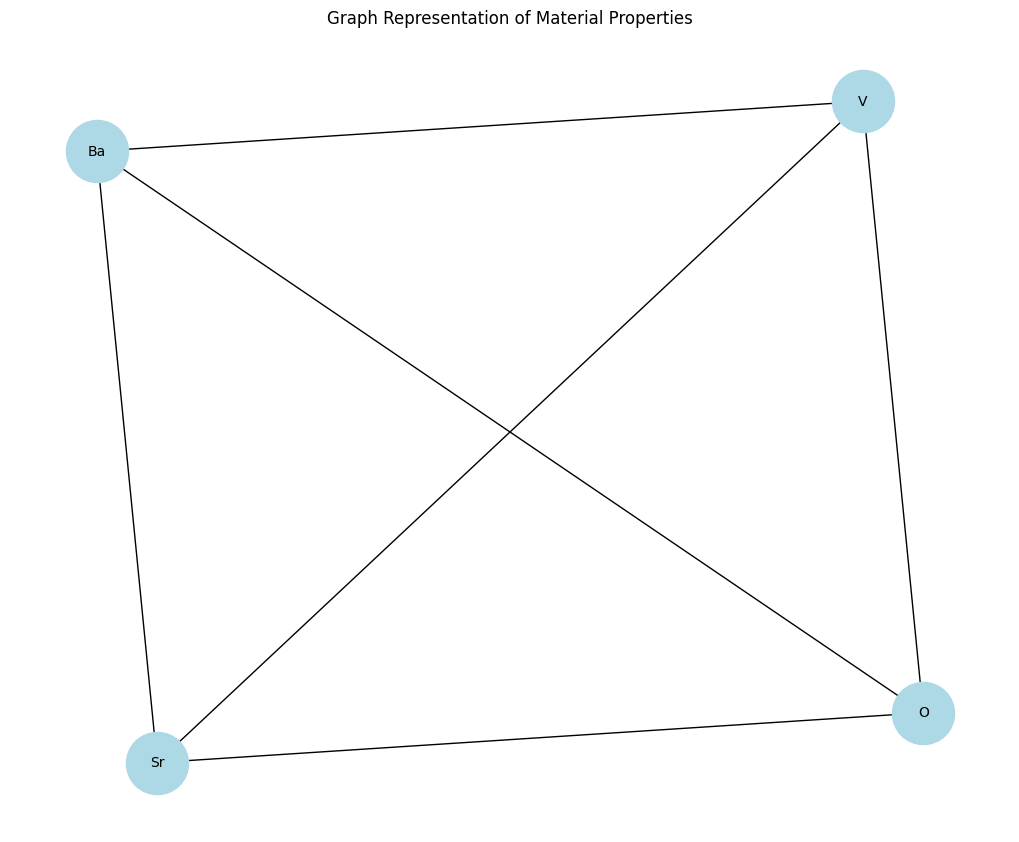

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(material_row):
    """
    Visualize the graph representation of a material's properties.

    Args:
        material_row (pd.Series): The row containing material data.
    """
    node_features = []
    edges = []

    # Create nodes and features
    for site in ['A site #1', 'A site #2', 'A site #3', 'B site #1', 'B site #2', 'B site #3', 'X site']:
        element = material_row[site]
        if pd.notna(element):
            # Create a node for each site with its corresponding features
            node_features.append({
                'element': element,
                'features': material_row[feature_columns].values
            })

    # Create edges based on relationships
    num_nodes = len(node_features)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            edges.append((i, j))
            edges.append((j, i))  # Undirected edges

    # Create a NetworkX graph for visualization
    G = nx.Graph()

    # Add nodes with features
    for i, node in enumerate(node_features):
        G.add_node(i, label=node['element'], features=node['features'])

    # Add edges
    G.add_edges_from(edges)

    # Draw the graph
    pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm
    labels = {i: G.nodes[i]['label'] for i in G.nodes}

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=2000, node_color='lightblue', font_size=10)

    # Display features of each node
    for i in range(len(node_features)):
        print(f"Node {i} ({G.nodes[i]['label']}): Features = {G.nodes[i]['features']}")

    plt.title("Graph Representation of Material Properties")
    plt.show()

# Example of visualizing a graph for a specific material in the dataset
example_material_row = df.iloc[0]  # Change index to visualize different materials
visualize_graph(example_material_row)


Epoch: 0, Loss: 0.2890, Train Acc: 0.8607, Test Acc: 0.8238
Epoch: 1, Loss: 0.3003, Train Acc: 0.8808, Test Acc: 0.8472
Epoch: 2, Loss: 0.2827, Train Acc: 0.8892, Test Acc: 0.8497
Epoch: 3, Loss: 0.2900, Train Acc: 0.8691, Test Acc: 0.8368
Epoch: 4, Loss: 0.2836, Train Acc: 0.8808, Test Acc: 0.8342
Epoch: 5, Loss: 0.2994, Train Acc: 0.8749, Test Acc: 0.8472
Epoch: 6, Loss: 0.2962, Train Acc: 0.8633, Test Acc: 0.8394
Epoch: 7, Loss: 0.2950, Train Acc: 0.8678, Test Acc: 0.8316
Epoch: 8, Loss: 0.2945, Train Acc: 0.8846, Test Acc: 0.8549
Epoch: 9, Loss: 0.2786, Train Acc: 0.8950, Test Acc: 0.8549
Epoch: 10, Loss: 0.2906, Train Acc: 0.8944, Test Acc: 0.8653
Epoch: 11, Loss: 0.2795, Train Acc: 0.8652, Test Acc: 0.8187
Epoch: 12, Loss: 0.2977, Train Acc: 0.8859, Test Acc: 0.8394
Epoch: 13, Loss: 0.2802, Train Acc: 0.8840, Test Acc: 0.8549
Epoch: 14, Loss: 0.2896, Train Acc: 0.8859, Test Acc: 0.8472
Epoch: 15, Loss: 0.2833, Train Acc: 0.8885, Test Acc: 0.8575
Epoch: 16, Loss: 0.2792, Train Acc

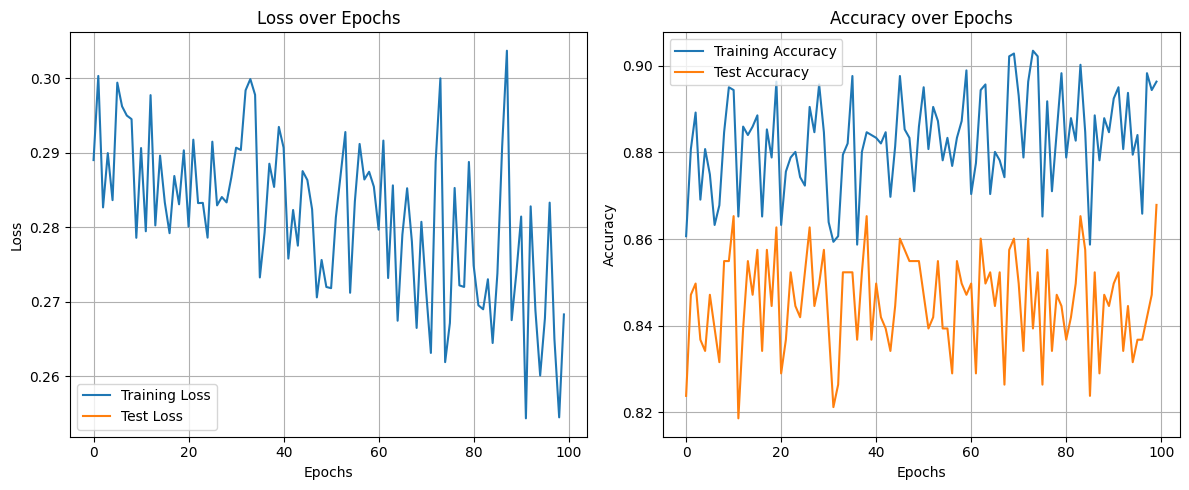

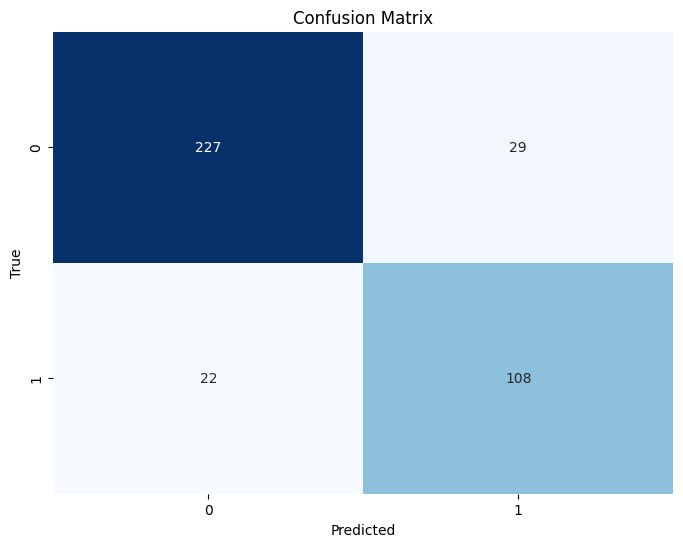

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Initialize lists to store the training and test accuracy and loss
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Modify the training and evaluation loop to store values
for epoch in range(100):
    loss = train()  # Train the model
    train_acc = test(train_loader)  # Evaluate on the training set
    test_acc = test(test_loader)    # Evaluate on the test set

    # Store the loss and accuracies
    train_losses.append(loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Plotting the training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plotting the training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Get predictions for the test set
all_preds = []
all_labels = []
for data in test_loader:
    data = data.to(device)
    out = model(data)
    preds = out.argmax(dim=1)  # Predicted class
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(data.y.view(-1).cpu().numpy())

# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds)
